# Лабораторная работа 2  
## Восстановление частоты несущей в системах с непрерывной фазовой модуляцией
Выполнила: Шаповалова Виктория, ИКТ-11М.  

В ходе лабораторной работы требовалось реализовать одну из известных схем (алгоритмов) для оценки частоты несущего колебания в системе с непрерывной фазовой модуляции.

### 1. Импорт библиотек  
В данном разделе импортируются библиотеки, которые будут использоваться в ходе выполнения работы.

In [105]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import scipy
from scipy import signal
from scipy.signal import max_len_seq
from ModulationPy import PSKModem
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import upfirdn,lfilter
import time

### 2. Задание параметров  
В данном разделе задаются параметры, которые будут использованы в ходе выполнения работы.

In [106]:
data_len = 10000 #длина информационной последовательности
fc = 5e4 #частота несущей
fs = 2e6 #частота дискретизации
sps = 10 #количество отсчетов на символ
BT = 0.4 #коэффициент модуляции
offset = 1000 #смещение по частоте
snr = 30 #отношение сигнал/шум
b_len = 100 #длина буфера суммы

### 3. Генерация случайного сигнала  
В данном разделе с помощью функции рандома генерируется информационный сигнал длины data_len для дальнейшей передачи.

In [107]:
data = [] 
data = np.random.randint(2, size = data_len)

### 4. GMSK-модуляция
В данном разделе создается функция, выполняющая модуляцию GMSK.  
GMSK (гауссовская частотная модуляция с минимальным сдвигом) - это один из видов непрерывной фазовой модуляции. Последовательность из прямоугольных импульсов проходит через гауссовский фильтр нижних частот для преобразования информационного потока из вида 0/1 в вид −1/+1, а затем фильтруется гауссовым фильтром таким образом, что прямоугольные импульсы преобразуются в импульсы гауссовского вида.  
Поэтому далее в первую очередь определена функция гауссовского ФНЧ, а затем уже сама функция GMSK модуляции.

C:\Users\Victoria\AppData\Local\Temp\ipykernel_1556\4037516477.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


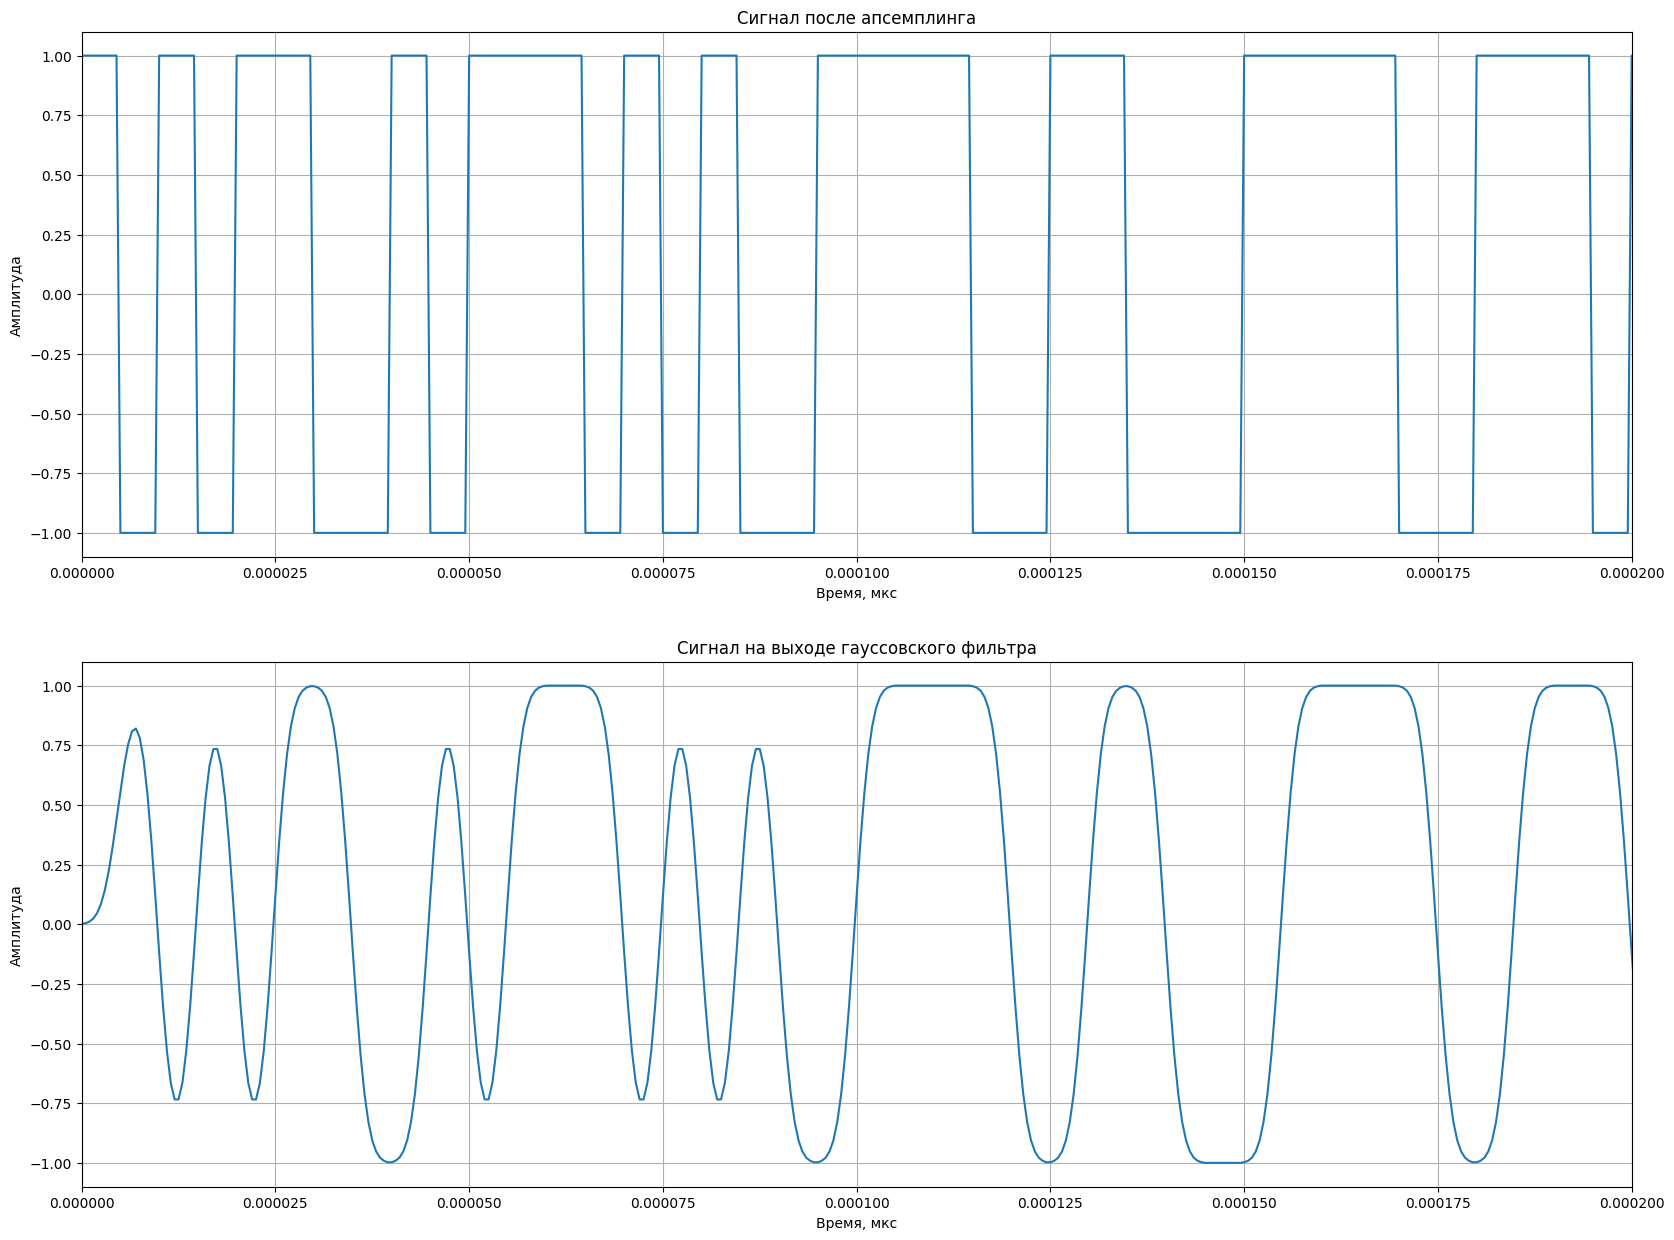

In [108]:
def gaussianLPF(BT, Tb, L, k):
    B = BT/Tb # bandwidth of the filter
    t = np.arange(start = -k*Tb, stop = k*Tb + Tb/L, step = Tb/L)
    h = B*np.sqrt(2*np.pi/(np.log(2)))*np.exp(-2 * (t*np.pi*B)**2 /(np.log(2)))
    h_norm=h/np.sum(h)
    return h_norm

def gmsk_mod(a,fc,fs,L,BT):
    
    Ts = 1/fs
    Tb = L*Ts 
    c_t = upfirdn(h=[1]*L, x=2*a-1, up = L)
    k=1
    h_t = gaussianLPF(BT,Tb,L,k)
    b_t = np.convolve(h_t,c_t,'full') 
    bnorm_t = b_t/max(abs(b_t)) # normalize the output of Gaussian LPF to +/-1
    h = 0.5
    # integrate to get phase information
    phi_t = lfilter(b = [1], a = [1,-1], x = bnorm_t*Ts) * h*np.pi/Tb

    I = np.cos(phi_t)
    Q = np.sin(phi_t)
    s_complex = I - Q

    
    fig, ((ax1, ax2)) = plt.subplots(2,1, figsize=(20,15))

    ax1.title.set_text('Сигнал после апсемплинга')
    ax1.plot(np.arange(0,len(c_t))*Ts,c_t)
    ax1.set_xlabel('Время, мкс')
    ax1.set_ylabel('Амплитуда')
    ax1.set_xlim(0,40*Tb)
    ax1.grid()

    ax2.title.set_text('Сигнал на выходе гауссовского фильтра')
    ax2.plot(np.arange(0,len(bnorm_t))*Ts,bnorm_t)
    ax2.set_xlabel('Время, мкс')
    ax2.set_ylabel('Амплитуда')
    ax2.set_xlim(0,40*Tb)
    ax2.grid()

    fig.show()
    return (s_complex)

data_mod = gmsk_mod(data, fc, fs, sps, BT)  # Модулируем данные ([0] - данные с переносом на несущую, [1] - данные без переноса)

### 5. Частотный сдвиг  
Далее к модулированным данным применяется частотный сдвиг. На рисунке представлено сдвинутое созвездие модулированных данных на 1 кГц.

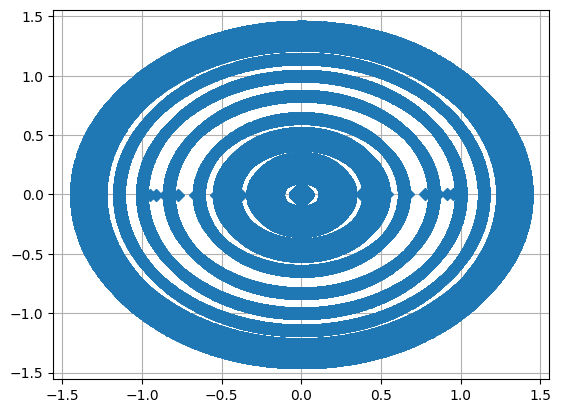

In [109]:
def freq_offset(data, offset, fs):
    Ts = 1/fs 
    t = np.arange(0, Ts*(len(data)-0.5), Ts) 
    data = data * np.exp(1j*2*np.pi*offset*t) 
    return data

data_mod_offset = freq_offset(data_mod, offset, fs*sps)

plt.figure(1)
plt.plot(np.real(data_mod_offset),np.imag(data_mod_offset), 'D')
plt.grid()

### 6. Добавление АБГШ  
К уже сдвинутому по частоте сигналу добавляется АБГШ. Параметром задается отношение сигнал/шум в дБ. В данном примере оно задано 30 дБ.

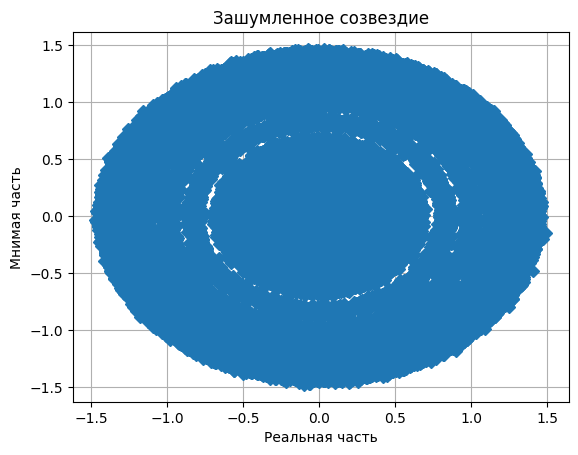

In [110]:
def awgn(signal, snr):
    sig_power = np.mean(np.abs(signal)**2) # calculate signal power
    sig_power_db = 10* np.log10(sig_power) # convert to dB

    noise_power_db = sig_power_db - snr
    noise_power = 10**(noise_power_db / 10)

    complex_noise = np.sqrt(noise_power/2)*(np.random.randn(len(signal)) + \
                                            np.random.randn(len(signal))*1j)

    return complex_noise

awgn_noise = awgn(data_mod_offset, snr)
tx = data_mod_offset + awgn_noise

plt.figure(1)
plt.plot(tx.real, tx.imag, 'D')
plt.title('Зашумленное созвездие')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")
plt.grid()

### 7. Оценка смещения  
Оценка смещения выполняется по схеме Open-loop delay-and-multiply.   

![lab2__1.PNG](lab2__1.PNG)  

На вход подается зашумленный сигнал, одна из его копий задерживается, берется ее комплексно-сопряженная копия и перемножается с исходным сигналом. Результат умножения содержит информацию о разности фаз или частот между двумя версиями сигнала. Далее происходит суммирование отсчетов и взятие аргумента для дальнейшей оценки частоты. Каждый раз после того, как k достигает значения N*L0 сумма считается заново для получения новой оценки смещения частоты.

Формула оценки частоты смещения несущей:

$$ \hat v = arg\{ \sum_{k=1}^{NL_0-1}[x(k)x^{*}(k-1)] \} * \dfrac{1}{2\pi DT_s} $$
где D - количество отсчётов, на которые делается задержка, $$ N*L_0 = \dfrac{T_0}{T_s} $$
$$ T_s = \dfrac{1}{f_s*sps} $$

В результате выполнения кода определяется среднее значение смещения и сравнивается с референсным значением для определения ошибки.   
Как видно по значениям, результат совпал с ожидаемым, погрешность незначительная, а значит схема работает корректно. Далее будет проведен анализ зависимости ошибки от отношения сигнал/шум.

In [111]:
FREQ_EST = [] # массив для значений смещения частоты
buf_counter = 0
sum = 0

for k in range(1, len(tx)):
    z_k = tx[k] * np.conj(tx[k-1])
    sum += z_k
    buf_counter += 1
    if buf_counter == b_len:
        v = (fs*sps/(2 * np.pi)) * np.angle(sum) 
        FREQ_EST.append(v) 
        buf_counter = 0
        sum = 0


print("Среднее значение смещения частоты: ", np.round(np.mean(FREQ_EST)), "Гц")
print("Ошибка вычисления частоты: ", np.round(offset-np.mean(FREQ_EST)), "Гц ")


Среднее значение смещения частоты:  1033.0 Гц
Ошибка вычисления частоты:  -33.0 Гц 


### 9. Анализ схемы  
В рамках исследования зависимости величины ошибки оценки смещения от величины отношения сигнал/шум построен график. Как видно по графику, с увеличением отношения сигнал/шум уменьшается ошибка определения смещения. 

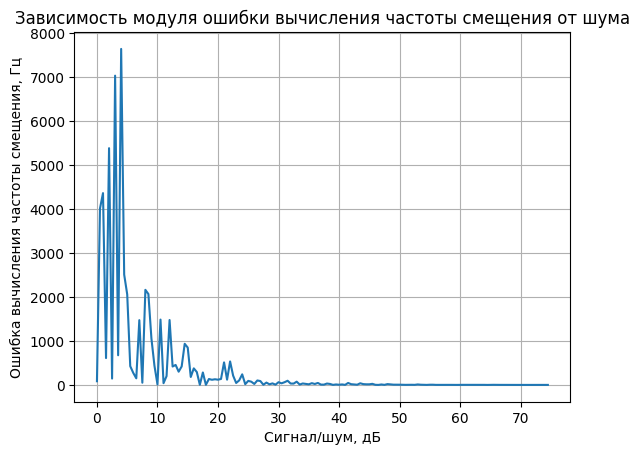

In [112]:
FREQ_EST_MASS = []

for i in range(0, 150, 1):
    awgn_noise = awgn(data_mod_offset, i/2)
    tx = data_mod_offset + awgn_noise

    freq_estimation = [] 
    buf_counter = 0
    sum = 0

    for k in range(1, len(tx)):
        z_k = tx[k] * np.conj(tx[k-1])
        sum += z_k
        buf_counter += 1
        if buf_counter == b_len: 
            v = (fs*sps/(2 * np.pi)) * np.angle(sum) 
            freq_estimation.append(v) 
            buf_counter = 0
            sum = 0
    FREQ_EST_MASS.append(np.mean(freq_estimation) - offset)


plt.figure(1)
plt.plot(np.arange(0, 150, 1)/2 , np.abs(FREQ_EST_MASS))
plt.title('Зависимость модуля ошибки вычисления частоты смещения от шума')
plt.ylabel("Ошибка вычисления частоты смещения, Гц")
plt.xlabel("Сигнал/шум, дБ")
plt.grid()

Далее построен график зависимости величины ошибки оценки частоты смещения от величины смещения. Отношение сигнал/шум задано 50 дБ, судя по предыдущему графику, данная величина не должна оказывать значительного влияния на результат.   
Полученный график показывает, что величина смещения частоты не влияет на ошибку оценки смещения.

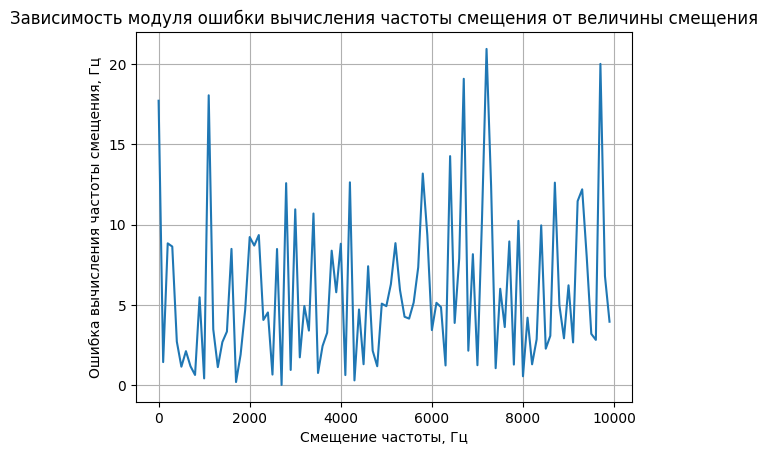

In [113]:
FREQ_EST_MASS = []

for i in range(0, 10000, 100):
    data_mod_offset = freq_offset(data_mod, i, fs*sps)

    awgn_noise = awgn(data_mod_offset, 50)
    tx = data_mod_offset + awgn_noise

    freq_estimation = [] 
    buf_counter = 0
    sum = 0

    for k in range(1, len(tx)):
        z_k = tx[k] * np.conj(tx[k-1])
        sum += z_k
        buf_counter += 1
        if buf_counter == b_len: 
            v = (fs*sps/(2 * np.pi)) * np.angle(sum) 
            freq_estimation.append(v) 
            buf_counter = 0
            sum = 0
    FREQ_EST_MASS.append(np.mean(freq_estimation) - i)


plt.figure(1)
plt.plot(np.arange(0, 10000, 100) , np.abs(FREQ_EST_MASS))
plt.title('Зависимость модуля ошибки вычисления частоты смещения от величины смещения')
plt.ylabel("Ошибка вычисления частоты смещения, Гц")
plt.xlabel("Смещение частоты, Гц")
plt.grid()

### Вывод  
В ходе лабораторной работы была сформирована информационная последовательность, которая была промодулирована непрерывной фазовой модуляцией GMSK. Затем модулированная последовательность была подвержена воздействию частотного сдвига и АБГШ. Далее была произведена оценка смещения с помощью схемы Open-loop delay-and-multiply. Тестирование было проведено при SNR = 30 дБ и частоте смещения 1 кГц. в результате среднее смещение практически совпадает с ожидаемым, что подтверждает корректную работу системы.  
Далее был проведен анализ работы схемы. Были построены графики зависимости модуля ошибки оценки смещения от величины отношения сигнал/шум и от величины смещения. В первом случае, при увеличении отношения сигнал/шум, ошибка, возникающая при средней оценке смещения, уменьшается. При отношении свыше 30 дБ, ошибка практически отсутствует. Второй график показывает хаотичное изменение значения ошибки, в результате чего можно сделать вывод, что величина смещения не влияет на возникающую оценку.
Таким образом, в ходе лабораторной работы была реализована одна из схем оценки частотного сдвига в системе с непрерывной фазовой модуляцией.